In [3]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import os

In [6]:
df = pd.read_csv(r"D:\Python\Casual\Machine_Learning\DataFoundamentalsProject\fundamentals\IRIS.csv", engine="c")

In [24]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [8]:
df.species.unique()
# Per capire quante classi ci sono nel taget

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [13]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [9]:
df.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

In [28]:
df.species = df["species"].astype("category")
# Specifico il tipo delle features

In [11]:
df.dtypes

sepal_length     float64
sepal_width      float64
petal_length     float64
petal_width      float64
species         category
dtype: object

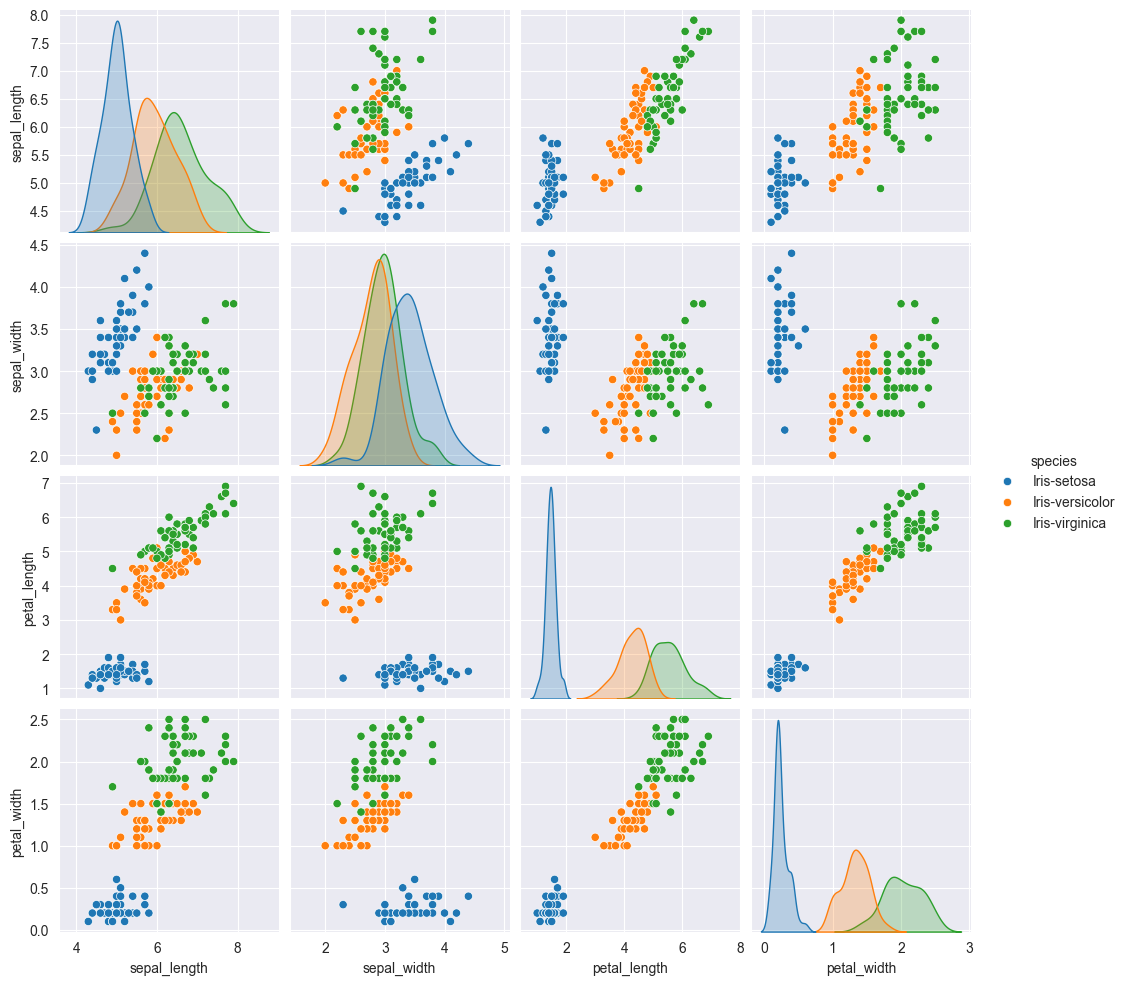

In [29]:
# Per investigare la correlazione tra le varie features
sns.pairplot(df, hue="species")

Vi è una correlazione positiva tra:
* petal_length e petal_width
* petal_width e sepal_length
* petal_lenght e sepal_length

<Axes: xlabel='species', ylabel='sepal_width'>

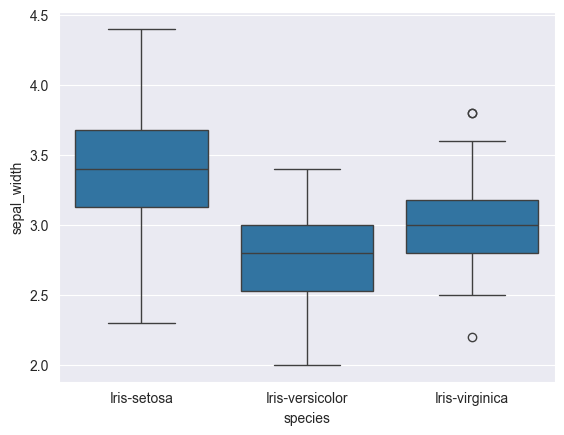

In [22]:
# Da fare ogni feature di interesse
sns.boxplot(data = df, x = 'species', y = 'sepal_width')

                            OLS Regression Results                            
Dep. Variable:            petal_width   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1877.
Date:                Wed, 08 May 2024   Prob (F-statistic):           5.78e-86
Time:                        18:14:41   Log-Likelihood:                 24.400
No. Observations:                 150   AIC:                            -44.80
Df Residuals:                     148   BIC:                            -38.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3665      0.040     -9.188   

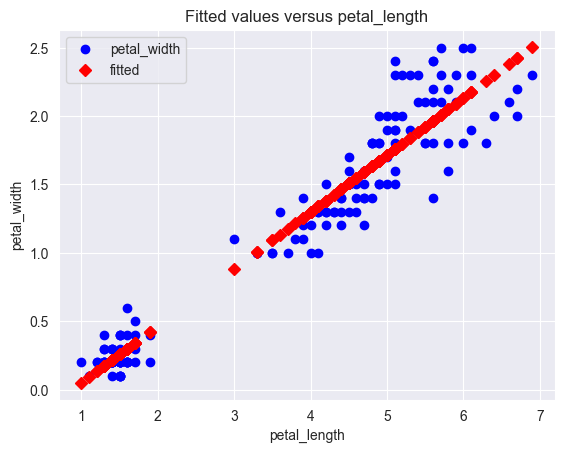

In [43]:
# Per avera una misura quantitavita della correlazione
linmod_int = sm.OLS(df.petal_width, sm.add_constant(df.petal_length))
res_int = linmod_int.fit()
sm.graphics.plot_fit(res_int,1, vlines=False)
print(res_int.summary())

In [47]:
# Confusion Matrix
corr_matrix = df.drop(["species"], axis=1).corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000
